<a href="https://colab.research.google.com/github/olasupoAjayi/ELENA-DA/blob/main/ELENA206_Health_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIM & OBJECTIVES

Aim: using Machine learning to identify predictors of morbidity and mortality in PPCM and using predictors to predict survival and morbidity.

Objectives:
1. Using simple statistical methods find features associated with each outcome variables. PCC

2. Using ML algorithms find features associated with each outcome variables.
Recursive Feature Elimination

3. Compare the results of 1 & 2 above

4. Use selected features to Predict outcome variables - ML algorithms (Supervised learning model)




# Load Relevant Libraries and Data

In [ ]:
import pandas as pd
import numpy as np

#statistics
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#machine learning

#install CATBOOST - uncomment on first run
!pip install catboost
!pip install scikeras

#ML Models
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#For Feature selections
from sklearn.model_selection import KFold, StratifiedKFold #RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#raw_data = pd.read_excel("/content/drive/MyDrive/Health_DA/ELENA_206.xlsx")
raw_data = pd.read_excel("ELENA_206.xlsx")

data1 = raw_data.copy()
print(data1.shape)
data1.head()

(206, 40)


,Number,Age,Parity,Ht_0,Wt_,BMI_0,SBP_0,DBP_0,HR_0,NYHA_0,...,Chol_0,Lasix=f,Accupril=hpt,Carvedilol=B blocker,Digoxin,NYHA_6,LVEDD_6,LVESD_6,EF_6,Survived
0,1,32,3.0,165.0,72.0,26.4,120.0,78.0,88,3,...,5.0,160.0,10.0,25.00,0.25,1.0,56.0,42.0,49.0,0
1,2,26,2.0,155.0,65.0,27.1,108.0,70.0,72,2,...,4.6,160.0,10.0,50.00,0.25,2.0,50.0,39.0,45.0,0
2,3,46,4.0,153.0,62.0,26.5,134.0,82.0,72,3,...,3.0,160.0,10.0,25.00,NaN,2.0,51.0,57.0,13.0,0
3,4,19,1.0,160.0,58.0,22.7,104.0,70.0,68,3,...,4.7,120.0,10.0,6.25,0.25,NaN,NaN,NaN,NaN,1
4,5,26,2.0,172.0,62.0,21.0,100.0,55.0,72,4,...,NaN,160.0,10.0,12.50,0.25,NaN,NaN,NaN,NaN,1


Change NAN to 0

In [ ]:
data1 = data1.fillna(0)

data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Number                206 non-null    int64  
 1   Age                   206 non-null    int64  
 2   Parity                206 non-null    float64
 3   Ht_0                  206 non-null    float64
 4   Wt_                   206 non-null    float64
 5   BMI_0                 206 non-null    float64
 6   SBP_0                 206 non-null    float64
 7   DBP_0                 206 non-null    float64
 8   HR_0                  206 non-null    int64  
 9   NYHA_0                206 non-null    int64  
 10  LVEDD_0               206 non-null    int64  
 11  LVESD_0               206 non-null    int64  
 12  EF_0                  206 non-null    int64  
 13  Hb_0                  206 non-null    float64
 14  MCV_0                 206 non-null    float64
 15  WCC_0                 2

# 1. STATISTICAL ASSOCIATION - USING PCC

Pearson Correlation Coefficient (PCC), designated as r,  is often used to find the association between two parametric attributes.

PCC usually fall within the range of -1 ≤ cc_value ≤ 1,


*   where a cc_value between 0 and 0.39 (or between 0 and -0.39) implies a weak positive (negative) relationship between the two attributes.

*    A value between 0.4 and 0.69 (or between -0.4 and -0.69) implies a moderate positive (negative) relationship.

*    While values between 0.7 and 1 (or between -0.7 and -1) imply strong positive (negative) relationship between the two attributes.

To determine the level of statistical importance of the correlation coefficient, probability value (p-value) is used. P-value helps determine the confidence level of the relationship between both attributes being considered. Level of significance (p-value) of 0.05 is used.

We used a t-test alongside two hypotheses:

*   Null hypothesis (H0) - there is no relationship between two attributes;
*   Alternate hypothesis (H1) - the two attributes are related.

A p-value less than 0.05 means that in about 95% of the cases, the null hypothesis does not hold, hence it is rejected.

A p-value greater or equal to 0.05 implies that in about 95% of the cases, the null hypothesis holds, hence accepted.

The smaller the p-value, the more likely you are to reject the null hypothesis.
https://www.scribbr.com/statistics/p-value/#:~:text=The%20p%2Dvalue%20only%20tells,your%20alternative%20hypothesis%20is%20true.



In [ ]:
original_headers = data1.columns
original_headers

Index(['Number', 'Age', 'Parity', 'Ht_0', 'Wt_', 'BMI_0', 'SBP_0', 'DBP_0',
       'HR_0', 'NYHA_0', 'LVEDD_0', 'LVESD_0', 'EF_0', 'Hb_0', 'MCV_0',
       'WCC_0', 'Plat_0', 'Na_0', 'K_0', 'Urea_0', 'Creat_0', 'TP_0', 'Alb',
       'TB_0', 'DB_0', 'IB_0', 'Al P_0', 'AST_0', 'ALT_0', 'GGT_0', 'Chol_0',
       'Lasix=f', 'Accupril=hpt', 'Carvedilol=B blocker', 'Digoxin', 'NYHA_6',
       'LVEDD_6', 'LVESD_6', 'EF_6', 'Survived'],
      dtype='object')

In [ ]:
features = ['Age', 'Parity', 'Ht_0', 'Wt_', 'BMI_0', 'SBP_0', 'DBP_0', 'HR_0', 'NYHA_0', 'LVEDD_0', 'LVESD_0', 'EF_0', 'Hb_0', 'MCV_0','WCC_0', 'Plat_0', 'Na_0', 'K_0', 'Urea_0', 'Creat_0', 'TP_0', 'Alb', 'TB_0', 'DB_0', 'IB_0', 'Al P_0', 'AST_0', 'ALT_0', 'GGT_0', 'Chol_0', 'Lasix=f', 'Accupril=hpt', 'Carvedilol=B blocker', 'Digoxin']

targets = ['NYHA_6', 'LVEDD_6', 'LVESD_6', 'EF_6', 'Survived']

Find associativity between each feature and the target

First Normalize the data to prevent exaggerated influence of higher values

In [ ]:
#using Min-Max
df = data1.values
mm  = sklearn.preprocessing.MinMaxScaler()
data1 = pd.DataFrame(mm.fit_transform(df), columns=original_headers)

#not even sure if this step is necessary, as results with and without seem to be the same

In [ ]:
for target in targets:
  t_seq = data1[target]

  for feature in features:
    f_seq = data1[feature]

    # calculate spearman's correlation
    coef, p = pearsonr(t_seq, f_seq)
    #print('\nPearsons corr. {0} vs {1} is {2:.5f}'.format(target, feature, coef))

    # interpret the co-ef significance
    #if (coef >= 0 and coef <= 0.39) or (coef >= -0.39 and coef <= 0):
      #print ('{0} and {1} are WEAKLY Associated'.format(target, feature))

    #if (coef >= 0.4 and coef <= 0.69) or (coef >= -0.69 and coef <= -0.49):
      #print ('{0} and {1} are MODERATELY Associated'.format(target, feature))

    #if (coef >= 0.7) or (coef <= -0.7):
      #print ('{0} and {1} are STRONGLY Associated'.format(target, feature))

    #interprete the significance
    alpha = 0.05
    if p > alpha:
      #print('p=%.5f. Insignificant correlation (fail to reject H0) ' % p)
      print('\n{0} vs {1} is {2:.5f} ({3:.5f})'.format(target, feature, coef, p))
    else:
	    #print('p=%.5f. Signifcant correlation (reject H0) ' % p)
      print('\n{0} vs {1} is {2:.5f} ({3:.5f})'.format(target, feature, coef, p))



NYHA_6 vs Age is -0.00575 (0.93466)

NYHA_6 vs Parity is -0.04669 (0.50516)

NYHA_6 vs Ht_0 is 0.04037 (0.56450)

NYHA_6 vs Wt_ is 0.08221 (0.24011)

NYHA_6 vs BMI_0 is 0.09092 (0.19371)

NYHA_6 vs SBP_0 is 0.03317 (0.63602)

NYHA_6 vs DBP_0 is 0.00960 (0.89102)

NYHA_6 vs HR_0 is 0.11618 (0.09630)

NYHA_6 vs NYHA_0 is 0.04262 (0.54301)

NYHA_6 vs LVEDD_0 is 0.02849 (0.68434)

NYHA_6 vs LVESD_0 is 0.03158 (0.65228)

NYHA_6 vs EF_0 is -0.04209 (0.54801)

NYHA_6 vs Hb_0 is -0.11780 (0.09173)

NYHA_6 vs MCV_0 is -0.13760 (0.04858)

NYHA_6 vs WCC_0 is -0.02669 (0.70339)

NYHA_6 vs Plat_0 is -0.11679 (0.09458)

NYHA_6 vs Na_0 is -0.02692 (0.70087)

NYHA_6 vs K_0 is 0.02485 (0.72298)

NYHA_6 vs Urea_0 is -0.00793 (0.90995)

NYHA_6 vs Creat_0 is 0.06216 (0.37474)

NYHA_6 vs TP_0 is -0.12929 (0.06399)

NYHA_6 vs Alb is -0.07743 (0.26864)

NYHA_6 vs TB_0 is -0.10773 (0.12325)

NYHA_6 vs DB_0 is -0.11011 (0.11514)

NYHA_6 vs IB_0 is -0.07530 (0.28209)

NYHA_6 vs Al P_0 is -0.09509 (0.17395)

NY

# 2. MACHINE LEARNING - RFE

The goal is to find the top N most influential variables for each of the target variables. 3 ML models would be used as estimators, i.e., CatBoost, RandomForest, and SVC








In [ ]:
'''Not sure if the target variables are also implicit variables for other target variables.
For example should NYHA_6, LVEDD, EF_6... be included when determining Survival and vice versa?

For now, would go with the assumption that they are all independent, hence target variables are not implicit variables for each other
'''


'Not sure if the target variables are also implicit variables for other target variables.\nFor example should NYHA_6, LVEDD, EF_6... be included when determining Survival and vice versa?\n\nFor now, would go with the assumption that they are all independent, hence target variables are not implicit variables for each other\n'

## ML Data

In [ ]:
#data
data1 = raw_data.copy()
data1 = data1.fillna(0)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Number                206 non-null    int64  
 1   Age                   206 non-null    int64  
 2   Parity                206 non-null    float64
 3   Ht_0                  206 non-null    float64
 4   Wt_                   206 non-null    float64
 5   BMI_0                 206 non-null    float64
 6   SBP_0                 206 non-null    float64
 7   DBP_0                 206 non-null    float64
 8   HR_0                  206 non-null    int64  
 9   NYHA_0                206 non-null    int64  
 10  LVEDD_0               206 non-null    int64  
 11  LVESD_0               206 non-null    int64  
 12  EF_0                  206 non-null    int64  
 13  Hb_0                  206 non-null    float64
 14  MCV_0                 206 non-null    float64
 15  WCC_0                 2

### Change datatype for some columns

In [ ]:
#data1.NYHA_6 = data1.NYHA_6.astype(np.int64)

In [ ]:
original_headers = data1.columns

features = ['Age', 'Parity', 'Ht_0', 'Wt_', 'BMI_0', 'SBP_0', 'DBP_0', 'HR_0', 'NYHA_0', 'LVEDD_0', 'LVESD_0', 'EF_0', 'Hb_0', 'MCV_0','WCC_0', 'Plat_0', 'Na_0', 'K_0', 'Urea_0', 'Creat_0', 'TP_0', 'Alb', 'TB_0', 'DB_0', 'IB_0', 'Al P_0', 'AST_0', 'ALT_0', 'GGT_0', 'Chol_0', 'Lasix=f', 'Accupril=hpt', 'Carvedilol=B blocker', 'Digoxin']

targets = ['NYHA_6', 'LVEDD_6', 'LVESD_6', 'EF_6', 'Survived']

### Min-Max Normalization

In [ ]:
#Normalization using Min-Max
df = data1.values
mm  = sklearn.preprocessing.MinMaxScaler()
data1 = pd.DataFrame(mm.fit_transform(df), columns=original_headers)

#not even sure if this step is necessary, as results with and without seem to be the same

### Create Training & Testing datasets for each target feature

In [ ]:
data1 = data1.drop('Number', axis = 1)
X = data1.drop(columns=targets, axis = 1)

#surv
Y_surv = data1['Survived'] #binary - no problem here

#NYHA
Y_NYHA = data1['NYHA_6'] # multi-class - 5 classes

#one hot encode Y_NYHA6 for RF and ANN
hot_NYHA =  keras.utils.to_categorical(Y_NYHA, num_classes = 5)
#for others
Y_NYHA = Y_NYHA.replace({0.00:0, 0.25:1, 0.50:2, 0.75:3, 1.00:4})

#EF
#Y_EF = pd.Series(np.where(data1['EF_6'] >= 0.50, 1, 0)) # converts EF6 to binary using 50 as threshold. Above 50 = 1 and values below 50 = 0
Y_EF = pd.Series(np.where(data1['EF_6'] >= 0.35, 1, 0)) # converts EF6 to binary using 35 as threshold. >= 35 => 1 and values < 35 => 0

#Others
Y_LVEDD = data1["LVEDD_6"]
Y_LVESD = data1["LVESD_6"]


print (X.shape, Y_NYHA.shape, Y_surv.shape, Y_EF.shape)

#print(Y_surv.value_counts(), Y_NYHA.value_counts(), Y_EF.value_counts())
print(Y_surv.value_counts(), Y_EF.value_counts())

(206, 34) (206,) (206,) (206,)
0.0    168
1.0     38
Name: Survived, dtype: int64 1    131
0     75
dtype: int64


## NN Models

In [ ]:
def MLP_model ():

  classifier = Sequential()

  #34 input, 1 output, unit = (34+1)/2 = 17
  classifier.add(Dense(units = 17, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))
  classifier.add(Dense(units = 17, kernel_initializer = 'uniform', activation = 'relu'))
  #final layer, sigmoid for binary and softmax for multi-class (NYHA-6)
  classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid')) #
  classifier.add(Dropout(0.1))
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

  return classifier

In [ ]:
#MLP multi-class
def MLP_model2 ():

  classifier = Sequential()

  #34 input, 1 output, unit = (34+1)/2 = 17
  classifier.add(Dense(units = 17, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))
  classifier.add(Dense(units = 17, kernel_initializer = 'uniform', activation = 'relu'))
  #final layer, sigmoid for binary and softmax for multi-class (NYHA-6)
  classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'softmax')) #
  classifier.add(Dropout(0.1))
  classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return classifier

## Result Plotters

In [ ]:
#plot for RFECV
def plotter(rfecv, model, desc):

  plt.figure()
  plt.xlabel("Feature Importance")
  plt.ylabel("Features")
  plt.title("Most influential factors for " + desc)

  xpoints = X.columns[rfecv.support_]

  if model == "coef":
    ypoints = rfecv.estimator_.coef_[0] ###check this for multiple features
  else:
    ypoints = rfecv.estimator_.feature_importances_

  if (len(ypoints) > 1):
    sorted_idx = ypoints.argsort()
    plt.barh(xpoints[sorted_idx], ypoints[sorted_idx])
  else:
    plt.barh(xpoints, ypoints)

  plt.show()

#plot 4 just RFE - Multi-class
def plotter2(rfe, model, desc):

  xpoints = X.columns[rfe.support_]

  if model == "coef":
    ypoints = rfe.estimator_.coef_#.tolist()
  else:
    ypoints = rfe.estimator_.feature_importances_

  fig = plt.figure(figsize=(10, 5))
  for idx, y in enumerate(ypoints, start = 1):
    sorted_idx = y.argsort()
    ax = fig.add_subplot(2, 3, idx)
    ax.plot(y[sorted_idx], xpoints[sorted_idx])
    ax.set_title("NYHA_Class " + str(idx))

  fig.tight_layout()


## SURVIVE

### Prominent features influencing Survival using RFECV (LR as estimator)

Optimal number of features : 1
Best features : Index(['K_0'], dtype='object')
Feature Ranks:  [12 27 10  8  3  4 26 16 22  7 23 24 29 28  9 21  6  1 13 11 31 30 15 25
 34 32 17 33 14 19 18 20  2  5]

====== FEATURE RANKINGS =====
Age 		 12
Parity 		 27
Ht_0 		 10
Wt_ 		 8
BMI_0 		 3
SBP_0 		 4
DBP_0 		 26
HR_0 		 16
NYHA_0 		 22
LVEDD_0 		 7
LVESD_0 		 23
EF_0 		 24
Hb_0 		 29
MCV_0 		 28
WCC_0 		 9
Plat_0 		 21
Na_0 		 6
K_0 		 1
Urea_0 		 13
Creat_0 		 11
TP_0 		 31
Alb 		 30
TB_0 		 15
DB_0 		 25
IB_0 		 34
Al P_0 		 32
AST_0 		 17
ALT_0 		 33
GGT_0 		 14
Chol_0 		 19
Lasix=f 		 18
Accupril=hpt 		 20
Carvedilol=B blocker 		 2
Digoxin 		 5


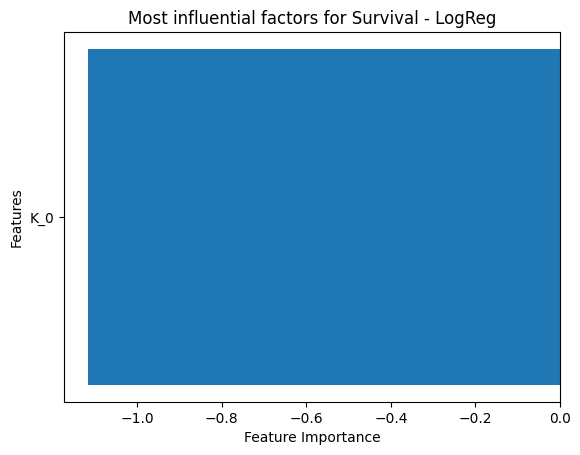

In [ ]:
rfecv = RFECV(LogisticRegression(random_state=77), step=1, cv=5, scoring="accuracy")
rfecv.fit(X, Y_surv)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
print('Feature Ranks: ', rfecv.ranking_)

print('\n====== FEATURE RANKINGS =====')
#for f,i, r in zip(X.columns,rfecv.estimator_.coef_, rfecv.ranking_):
for f, r in zip(X.columns, rfecv.ranking_):
  print('{} \t\t {}'.format(f, r))

plotter(rfecv, "coef", "Survival - LogReg")

In [ ]:
rfecv.estimator_.coef_
#rfecv.estimator_.feature_importances_

array([[-1.11737017]])

### Prominent features influencing Survival using just RFE (LR as estimator)

Optimal number of features : 15
Best features : Index(['Age', 'Ht_0', 'Wt_', 'BMI_0', 'SBP_0', 'LVEDD_0', 'WCC_0', 'Na_0',
       'K_0', 'Urea_0', 'Creat_0', 'TB_0', 'GGT_0', 'Carvedilol=B blocker',
       'Digoxin'],
      dtype='object')
Feature Ranks:  [ 1 13  1  1  1  1 12  2  8  1  9 10 15 14  1  7  1  1  1  1 17 16  1 11
 20 18  3 19  1  5  4  6  1  1]

====== FEATURE RANKINGS =====
Age 		 1
Parity 		 13
Ht_0 		 1
Wt_ 		 1
BMI_0 		 1
SBP_0 		 1
DBP_0 		 12
HR_0 		 2
NYHA_0 		 8
LVEDD_0 		 1
LVESD_0 		 9
EF_0 		 10
Hb_0 		 15
MCV_0 		 14
WCC_0 		 1
Plat_0 		 7
Na_0 		 1
K_0 		 1
Urea_0 		 1
Creat_0 		 1
TP_0 		 17
Alb 		 16
TB_0 		 1
DB_0 		 11
IB_0 		 20
Al P_0 		 18
AST_0 		 3
ALT_0 		 19
GGT_0 		 1
Chol_0 		 5
Lasix=f 		 4
Accupril=hpt 		 6
Carvedilol=B blocker 		 1
Digoxin 		 1


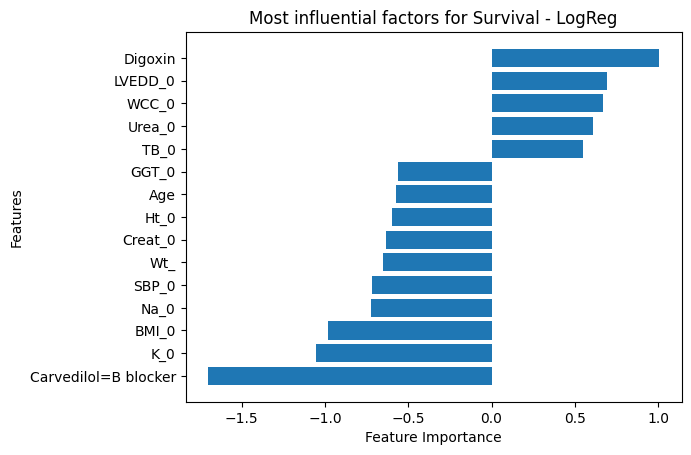

In [ ]:
estimator = LogisticRegression(random_state=77)

rfe = RFE(estimator, n_features_to_select=15, step = 1)
rfe.fit(X, Y_surv)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])
print('Feature Ranks: ', rfe.ranking_)

print('\n====== FEATURE RANKINGS =====')
#for f,i, r in zip(X.columns,rfecv.estimator_.coef_, rfecv.ranking_):
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f, r))

plotter(rfe, "coef", "Survival - LogReg")

### Prominent features influencing Survival using RFECV (SVC as estimator)

Optimal number of features : 1
Best features : Index(['DB_0'], dtype='object')
[32 21 22 25  9 12 34 33 31 10 15 14 26 19  7 24 30 13  6  8 20 16  2  1
  3 27  4 29  5 18 17 23 11 28]

====== FEATURE RANKINGS =====
Age 		 32
Parity 		 21
Ht_0 		 22
Wt_ 		 25
BMI_0 		 9
SBP_0 		 12
DBP_0 		 34
HR_0 		 33
NYHA_0 		 31
LVEDD_0 		 10
LVESD_0 		 15
EF_0 		 14
Hb_0 		 26
MCV_0 		 19
WCC_0 		 7
Plat_0 		 24
Na_0 		 30
K_0 		 13
Urea_0 		 6
Creat_0 		 8
TP_0 		 20
Alb 		 16
TB_0 		 2
DB_0 		 1
IB_0 		 3
Al P_0 		 27
AST_0 		 4
ALT_0 		 29
GGT_0 		 5
Chol_0 		 18
Lasix=f 		 17
Accupril=hpt 		 23
Carvedilol=B blocker 		 11
Digoxin 		 28


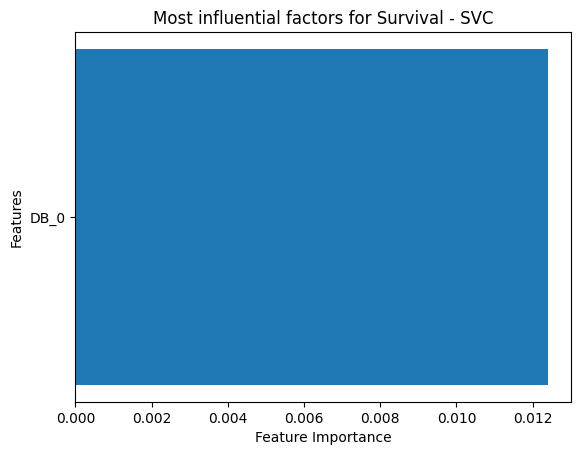

In [ ]:
#X_train, X_test, Y_train, Y_test =  split_scale(X, Y_surv)

rfecv = RFECV(SVC(kernel = 'linear', random_state=77, probability=True), step=1, cv=5, scoring = 'accuracy')
rfecv.fit(X, Y_surv)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
print(rfecv.ranking_)

print('\n====== FEATURE RANKINGS =====')
#for f,i, r in zip(X.columns,rfecv.estimator_.coef_, rfecv.ranking_):
for f, r in zip(X.columns, rfecv.ranking_):
  print('{} \t\t {}'.format(f, r))

plotter(rfecv, "coef", "Survival - SVC")

### Prominent features influencing Survival using Just RFE (SVC as estimator)

Optimal number of features : 15
Best features : Index(['BMI_0', 'SBP_0', 'LVEDD_0', 'LVESD_0', 'EF_0', 'WCC_0', 'K_0',
       'Urea_0', 'Creat_0', 'TB_0', 'DB_0', 'IB_0', 'AST_0', 'GGT_0',
       'Carvedilol=B blocker'],
      dtype='object')

====== FEATURE RANKINGS =====
Age 		 18
Parity 		 7
Ht_0 		 8
Wt_ 		 11
BMI_0 		 1
SBP_0 		 1
DBP_0 		 20
HR_0 		 19
NYHA_0 		 17
LVEDD_0 		 1
LVESD_0 		 1
EF_0 		 1
Hb_0 		 12
MCV_0 		 5
WCC_0 		 1
Plat_0 		 10
Na_0 		 16
K_0 		 1
Urea_0 		 1
Creat_0 		 1
TP_0 		 6
Alb 		 2
TB_0 		 1
DB_0 		 1
IB_0 		 1
Al P_0 		 13
AST_0 		 1
ALT_0 		 15
GGT_0 		 1
Chol_0 		 4
Lasix=f 		 3
Accupril=hpt 		 9
Carvedilol=B blocker 		 1
Digoxin 		 14


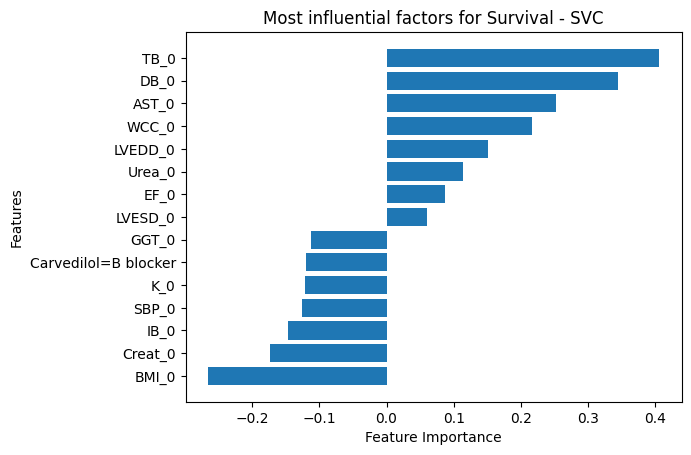

In [ ]:
estimator = SVC(kernel = 'linear', random_state=77, probability=True)

rfe = RFE(estimator, n_features_to_select=15, step = 1)
rfe.fit(X, Y_surv)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])

print('\n====== FEATURE RANKINGS =====')
#for f,i, r in zip(X.columns,rfecv.estimator_.feature_importances_, rfecv.ranking_):
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f,  r))

plotter(rfe, "coef", "Survival - SVC")

### Prominent features influencing Survival using RFECV (RF as estimator)

Optimal number of features : 20
Best features : Index(['Age', 'Ht_0', 'Wt_', 'BMI_0', 'SBP_0', 'DBP_0', 'HR_0', 'LVEDD_0',
       'LVESD_0', 'EF_0', 'MCV_0', 'WCC_0', 'Plat_0', 'Na_0', 'K_0', 'Urea_0',
       'Creat_0', 'Alb', 'ALT_0', 'Chol_0'],
      dtype='object')

====== FEATURE RANKINGS =====
Age 		 1
Parity 		 12
Ht_0 		 1
Wt_ 		 1
BMI_0 		 1
SBP_0 		 1
DBP_0 		 1
HR_0 		 1
NYHA_0 		 14
LVEDD_0 		 1
LVESD_0 		 1
EF_0 		 1
Hb_0 		 8
MCV_0 		 1
WCC_0 		 1
Plat_0 		 1
Na_0 		 1
K_0 		 1
Urea_0 		 1
Creat_0 		 1
TP_0 		 4
Alb 		 1
TB_0 		 5
DB_0 		 2
IB_0 		 9
Al P_0 		 7
AST_0 		 10
ALT_0 		 1
GGT_0 		 6
Chol_0 		 1
Lasix=f 		 3
Accupril=hpt 		 13
Carvedilol=B blocker 		 11
Digoxin 		 15


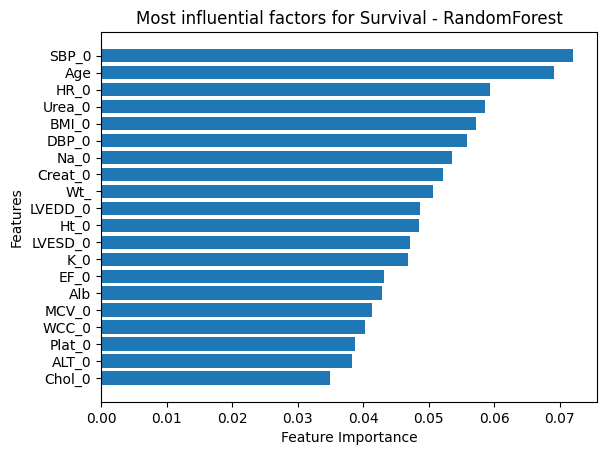

In [ ]:
rfecv = RFECV(estimator=RandomForestClassifier(n_estimators = 100, random_state = 77), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, Y_surv)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])

print('\n====== FEATURE RANKINGS =====')
#for f,i, r in zip(X.columns,rfecv.estimator_.feature_importances_, rfecv.ranking_):
for f, r in zip(X.columns, rfecv.ranking_):
  print('{} \t\t {}'.format(f,  r))

plotter(rfecv, "RF", "Survival - RandomForest")

### Prominent features influencing Survival using just RFE (RF as estimator)

Optimal number of features : 15
Best features : Index(['Age', 'Ht_0', 'Wt_', 'BMI_0', 'SBP_0', 'DBP_0', 'HR_0', 'LVEDD_0',
       'LVESD_0', 'WCC_0', 'Na_0', 'K_0', 'Urea_0', 'Creat_0', 'DB_0'],
      dtype='object')

====== FEATURE RANKINGS =====
Age 		 1
Parity 		 12
Ht_0 		 1
Wt_ 		 1
BMI_0 		 1
SBP_0 		 1
DBP_0 		 1
HR_0 		 1
NYHA_0 		 18
LVEDD_0 		 1
LVESD_0 		 1
EF_0 		 9
Hb_0 		 17
MCV_0 		 2
WCC_0 		 1
Plat_0 		 8
Na_0 		 1
K_0 		 1
Urea_0 		 1
Creat_0 		 1
TP_0 		 7
Alb 		 11
TB_0 		 10
DB_0 		 1
IB_0 		 19
Al P_0 		 14
AST_0 		 4
ALT_0 		 5
GGT_0 		 13
Chol_0 		 3
Lasix=f 		 6
Accupril=hpt 		 16
Carvedilol=B blocker 		 15
Digoxin 		 20


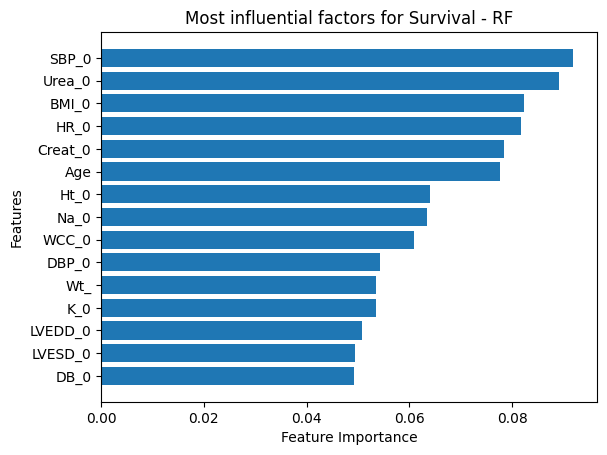

In [ ]:
estimator=RandomForestRegressor(n_estimators = 100, oob_score=True, random_state = 77)
kf = KFold(n_splits=5, shuffle=True, random_state=77)

rfe = RFE(estimator, n_features_to_select=15, step = 1)
rfe.fit(X, Y_surv)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])

print('\n====== FEATURE RANKINGS =====')
#for f,i, r in zip(X.columns,rfecv.estimator_.feature_importances_, rfecv.ranking_):
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f,  r))

plotter(rfe, "RF", "Survival - RF")

### Prominent features influencing Survival using RFECV (CatBoost as estimator)

Optimal number of features : 2
Best features : Index(['Age', 'Creat_0'], dtype='object')
[ 1 30  8 13  5 10 28  6 14 20 18 26 24 23 31 15  9  7  4  1 25 22 21 32
 27 16 17 33 12 19 11 29  2  3]

====== FEATURE RANKINGS =====
Age 		 1
Parity 		 30
Ht_0 		 8
Wt_ 		 13
BMI_0 		 5
SBP_0 		 10
DBP_0 		 28
HR_0 		 6
NYHA_0 		 14
LVEDD_0 		 20
LVESD_0 		 18
EF_0 		 26
Hb_0 		 24
MCV_0 		 23
WCC_0 		 31
Plat_0 		 15
Na_0 		 9
K_0 		 7
Urea_0 		 4
Creat_0 		 1
TP_0 		 25
Alb 		 22
TB_0 		 21
DB_0 		 32
IB_0 		 27
Al P_0 		 16
AST_0 		 17
ALT_0 		 33
GGT_0 		 12
Chol_0 		 19
Lasix=f 		 11
Accupril=hpt 		 29
Carvedilol=B blocker 		 2
Digoxin 		 3


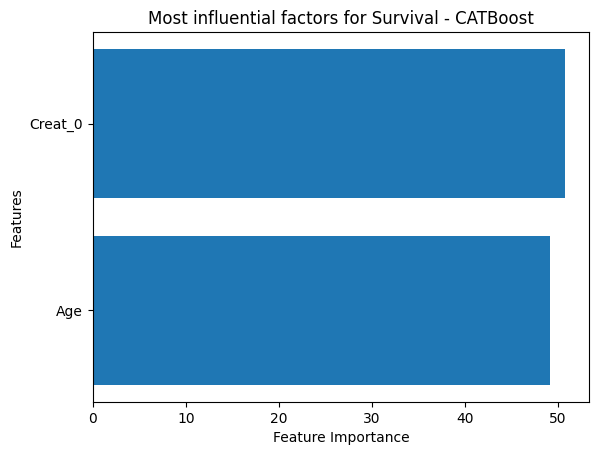

In [ ]:
estimator = CatBoostClassifier(iterations=100, random_seed= 77, verbose = 0)
rfecv = RFECV(estimator, step=1, cv=10, scoring = 'accuracy')
#rfecv = RFE(estimator, step=1, n_features_to_select=10)
rfecv.fit(X, Y_surv)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
#print('Original features :', X.columns)
print(rfecv.ranking_) #'Ranking: ', X.columns[rfecv.ranking_])


print('\n====== FEATURE RANKINGS =====')
for f, r in zip(X.columns, rfecv.ranking_):
  print('{} \t\t {}'.format(f, r))

plotter(rfecv, "FI", "Survival - CATBoost")

### Prominent features influencing Survival using Just RFE (CatBoost as estimator)

Streaming output truncated to the last 5000 lines.
50:	learn: 0.4821943	total: 141ms	remaining: 1.25s
51:	learn: 0.4793497	total: 148ms	remaining: 1.27s
52:	learn: 0.4762328	total: 152ms	remaining: 1.28s
53:	learn: 0.4731374	total: 155ms	remaining: 1.28s
54:	learn: 0.4701762	total: 157ms	remaining: 1.27s
55:	learn: 0.4674104	total: 160ms	remaining: 1.27s
56:	learn: 0.4649720	total: 162ms	remaining: 1.26s
57:	learn: 0.4619543	total: 165ms	remaining: 1.26s
58:	learn: 0.4592143	total: 168ms	remaining: 1.25s
59:	learn: 0.4566336	total: 171ms	remaining: 1.25s
60:	learn: 0.4535924	total: 173ms	remaining: 1.24s
61:	learn: 0.4515179	total: 175ms	remaining: 1.24s
62:	learn: 0.4486423	total: 178ms	remaining: 1.23s
63:	learn: 0.4455206	total: 180ms	remaining: 1.23s
64:	learn: 0.4438091	total: 183ms	remaining: 1.22s
65:	learn: 0.4421399	total: 185ms	remaining: 1.22s
66:	learn: 0.4398983	total: 187ms	remaining: 1.21s
67:	learn: 0.4381170	total: 190ms	remaining: 1.2s
68:	learn: 0.4362647	total: 192m

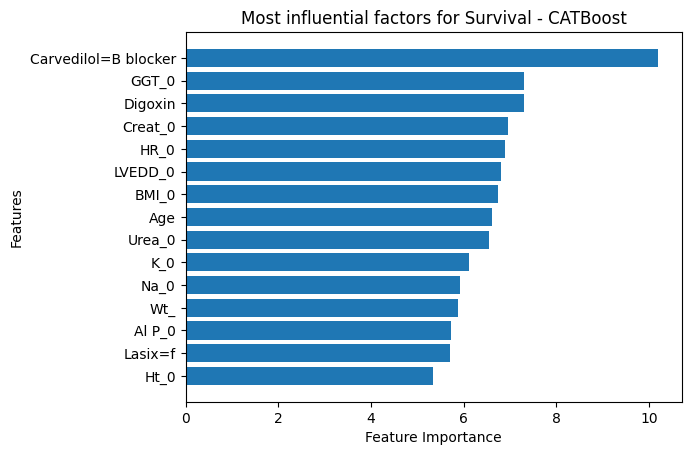

In [ ]:
estimator = CatBoostClassifier(iterations=500, random_seed= 77)
rfe = RFE(estimator, step=1, n_features_to_select=15)
rfe.fit(X, Y_surv)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])

print('\n====== FEATURE RANKINGS =====')
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f, r))

plotter(rfe, "FI", "Survival - CATBoost")

## NYHA

### Prominent Features influencing Y_NYHA using RFE (Multi-nodal LR as estimator)

In [ ]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(random_state=77, multi_class='multinomial')

rfe = RFE(estimator, n_features_to_select=10, step = 1)
rfe.fit(X, Y_NYHA)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])
print('Feature Ranks: ', rfe.ranking_)

print('\n====== FEATURE RANKINGS =====')
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f, r))


plotter2(rfe, "coef", "NYHA - LogReg")

### Prominent Features influencing Y_NYHA using RFE (RF as estimator)

Optimal number of features : 15
Best features : Index(['Age', 'Ht_0', 'Wt_', 'BMI_0', 'SBP_0', 'DBP_0', 'HR_0', 'LVESD_0',
       'WCC_0', 'Na_0', 'K_0', 'Urea_0', 'Creat_0', 'Alb', 'Lasix=f'],
      dtype='object')

====== FEATURE RANKINGS =====
Age 		 1
Parity 		 13
Ht_0 		 1
Wt_ 		 1
BMI_0 		 1
SBP_0 		 1
DBP_0 		 1
HR_0 		 1
NYHA_0 		 10
LVEDD_0 		 16
LVESD_0 		 1
EF_0 		 3
Hb_0 		 7
MCV_0 		 8
WCC_0 		 1
Plat_0 		 17
Na_0 		 1
K_0 		 1
Urea_0 		 1
Creat_0 		 1
TP_0 		 18
Alb 		 1
TB_0 		 20
DB_0 		 12
IB_0 		 9
Al P_0 		 6
AST_0 		 5
ALT_0 		 11
GGT_0 		 14
Chol_0 		 4
Lasix=f 		 1
Accupril=hpt 		 15
Carvedilol=B blocker 		 2
Digoxin 		 19


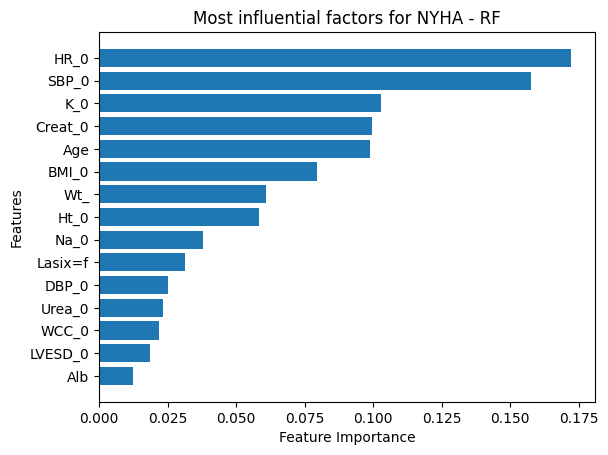

In [ ]:
estimator=RandomForestRegressor(n_estimators = 100, oob_score=True, random_state = 77)
#kf = KFold(n_splits=5, shuffle=True, random_state=77)

#rfecv = RFECV(estimator, cv=kf, step=0.1, scoring='neg_root_mean_squared_error')
rfe = RFE(estimator, n_features_to_select=15, step = 1)
rfe.fit(X, hot_NYHA)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])

print('\n====== FEATURE RANKINGS =====')
#for f,i, r in zip(X.columns,rfecv.estimator_.feature_importances_, rfecv.ranking_):
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f,  r))

plotter(rfe, "RF", "NYHA - RF")

### Prominent Features influencing Y_NYHA using RFE (CatBoost as estimator)

Optimal number of features : 15
Best features : Index(['Age', 'Ht_0', 'Wt_', 'BMI_0', 'SBP_0', 'DBP_0', 'HR_0', 'LVEDD_0',
       'EF_0', 'MCV_0', 'K_0', 'Urea_0', 'Creat_0', 'AST_0', 'Chol_0'],
      dtype='object')

====== FEATURE RANKINGS =====
Age 		 1
Parity 		 16
Ht_0 		 1
Wt_ 		 1
BMI_0 		 1
SBP_0 		 1
DBP_0 		 1
HR_0 		 1
NYHA_0 		 14
LVEDD_0 		 1
LVESD_0 		 8
EF_0 		 1
Hb_0 		 17
MCV_0 		 1
WCC_0 		 10
Plat_0 		 13
Na_0 		 11
K_0 		 1
Urea_0 		 1
Creat_0 		 1
TP_0 		 19
Alb 		 3
TB_0 		 4
DB_0 		 7
IB_0 		 18
Al P_0 		 15
AST_0 		 1
ALT_0 		 5
GGT_0 		 6
Chol_0 		 1
Lasix=f 		 2
Accupril=hpt 		 12
Carvedilol=B blocker 		 9
Digoxin 		 20


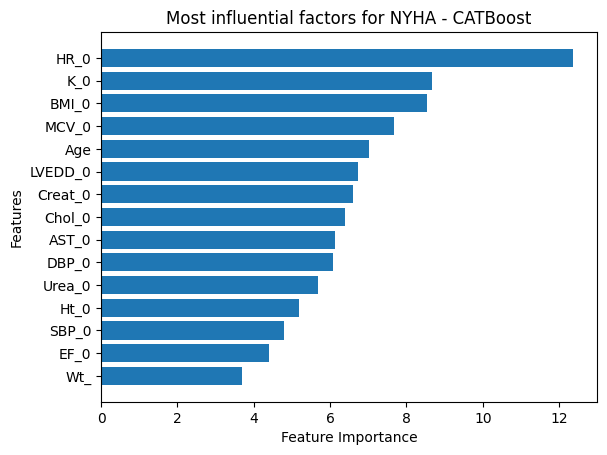

In [ ]:
estimator = CatBoostClassifier(iterations=100, loss_function='MultiClass', verbose=False, random_seed= 77)

rfe = RFE(estimator, step=1, n_features_to_select=15)
rfe.fit(X, Y_NYHA)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])

print('\n====== FEATURE RANKINGS =====')
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f, r))

plotter(rfe, "FI", "NYHA - CATBoost")

### Prominent Features of NYHA-6 using RFE (SVM Wrapper)

Optimal number of features : 15
Best features : Index(['Age', 'Ht_0', 'BMI_0', 'DBP_0', 'LVEDD_0', 'WCC_0', 'Plat_0', 'K_0',
       'Urea_0', 'Creat_0', 'AST_0', 'GGT_0', 'Accupril=hpt',
       'Carvedilol=B blocker', 'Digoxin'],
      dtype='object')

====== FEATURE RANKINGS =====
Age 		 1
Parity 		 9
Ht_0 		 1
Wt_ 		 2
BMI_0 		 1
SBP_0 		 10
DBP_0 		 1
HR_0 		 4
NYHA_0 		 12
LVEDD_0 		 1
LVESD_0 		 8
EF_0 		 3
Hb_0 		 13
MCV_0 		 18
WCC_0 		 1
Plat_0 		 1
Na_0 		 5
K_0 		 1
Urea_0 		 1
Creat_0 		 1
TP_0 		 11
Alb 		 15
TB_0 		 7
DB_0 		 19
IB_0 		 17
Al P_0 		 20
AST_0 		 1
ALT_0 		 14
GGT_0 		 1
Chol_0 		 16
Lasix=f 		 6
Accupril=hpt 		 1
Carvedilol=B blocker 		 1
Digoxin 		 1


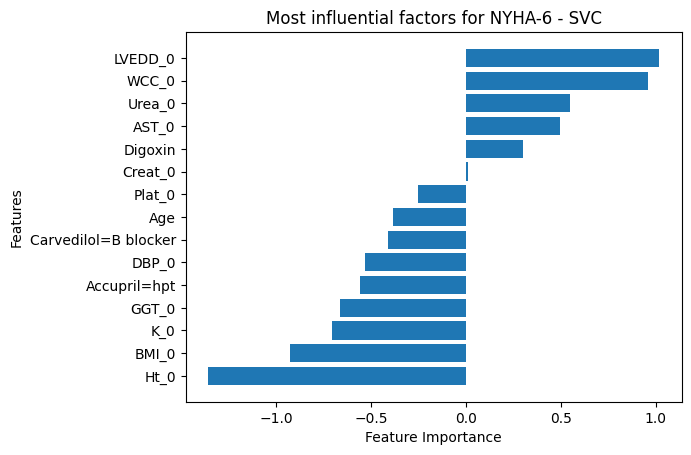

In [ ]:
estimator = SVC(kernel = 'linear', random_state=77, probability=True)

rfe = RFE(estimator, n_features_to_select=15, step = 1)
rfe.fit(X, Y_NYHA)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])

print('\n====== FEATURE RANKINGS =====')
#for f,i, r in zip(X.columns,rfecv.estimator_.feature_importances_, rfecv.ranking_):
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f,  r))

plotter(rfe, "coef", "NYHA-6 - SVC")

### Prominent Features of NYHA-6 using RFE (ANN as estimator)

In [ ]:
'''
ANN does not return feature importance or coef - BURSTED!!

estimator = KerasClassifier(build_fn= MLP_model2, epochs=500, batch_size=50, verbose=0, random_state = 77)

rfe = RFE(estimator, step=1, n_features_to_select=15)
rfe.fit(X, hot_NYHA)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])

print('\n====== FEATURE RANKINGS =====')
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f, r))

plotter(rfe, "FI", "NYHA - NN")
'''

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


ValueError: when `importance_getter=='auto'`, the underlying estimator KerasClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

## EF_6

### Prominent Features influencing Y_EF6 using RFE (LR as estimator)

Optimal number of features : 15
Best features : Index(['Wt_', 'BMI_0', 'SBP_0', 'HR_0', 'LVEDD_0', 'LVESD_0', 'EF_0', 'Hb_0',
       'MCV_0', 'Plat_0', 'Al P_0', 'GGT_0', 'Chol_0', 'Carvedilol=B blocker',
       'Digoxin'],
      dtype='object')
Feature Ranks:  [17 11  6  1  1  1 14  1  4  1  1  1  1  1 20  1  2 12  9  7  3 15 13 19
 16  1  8  5  1  1 10 18  1  1]

====== FEATURE RANKINGS =====
Age 		 17
Parity 		 11
Ht_0 		 6
Wt_ 		 1
BMI_0 		 1
SBP_0 		 1
DBP_0 		 14
HR_0 		 1
NYHA_0 		 4
LVEDD_0 		 1
LVESD_0 		 1
EF_0 		 1
Hb_0 		 1
MCV_0 		 1
WCC_0 		 20
Plat_0 		 1
Na_0 		 2
K_0 		 12
Urea_0 		 9
Creat_0 		 7
TP_0 		 3
Alb 		 15
TB_0 		 13
DB_0 		 19
IB_0 		 16
Al P_0 		 1
AST_0 		 8
ALT_0 		 5
GGT_0 		 1
Chol_0 		 1
Lasix=f 		 10
Accupril=hpt 		 18
Carvedilol=B blocker 		 1
Digoxin 		 1


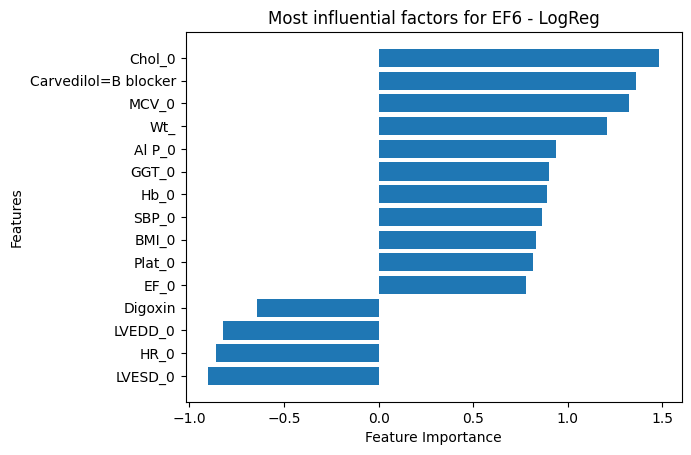

In [ ]:
estimator = LogisticRegression(random_state=77)

rfe = RFE(estimator, n_features_to_select=15, step = 1)
rfe.fit(X, Y_EF)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])
print('Feature Ranks: ', rfe.ranking_)

print('\n====== FEATURE RANKINGS =====')
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f, r))

plotter(rfe, "coef", "EF6 - LogReg")

### Prominent Features influencing Y_EF6 using RFE (RF as estimator)

Optimal number of features : 15
Best features : Index(['Age', 'Ht_0', 'SBP_0', 'DBP_0', 'HR_0', 'LVESD_0', 'EF_0', 'Hb_0',
       'MCV_0', 'WCC_0', 'Plat_0', 'Creat_0', 'Alb', 'ALT_0', 'Chol_0'],
      dtype='object')

====== FEATURE RANKINGS =====
Age 		 1
Parity 		 14
Ht_0 		 1
Wt_ 		 6
BMI_0 		 12
SBP_0 		 1
DBP_0 		 1
HR_0 		 1
NYHA_0 		 16
LVEDD_0 		 2
LVESD_0 		 1
EF_0 		 1
Hb_0 		 1
MCV_0 		 1
WCC_0 		 1
Plat_0 		 1
Na_0 		 13
K_0 		 8
Urea_0 		 3
Creat_0 		 1
TP_0 		 7
Alb 		 1
TB_0 		 10
DB_0 		 5
IB_0 		 17
Al P_0 		 11
AST_0 		 9
ALT_0 		 1
GGT_0 		 4
Chol_0 		 1
Lasix=f 		 15
Accupril=hpt 		 19
Carvedilol=B blocker 		 18
Digoxin 		 20


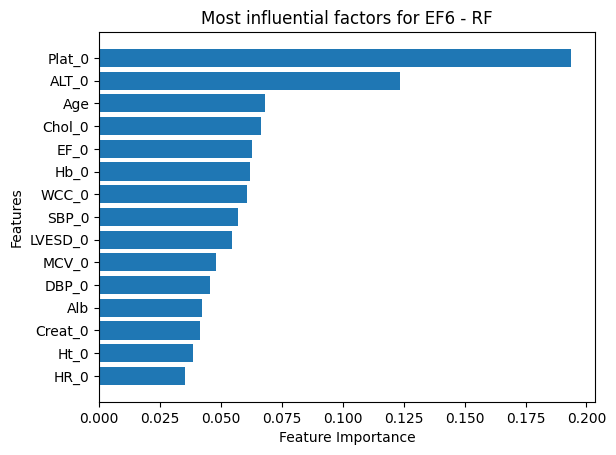

In [ ]:
estimator=RandomForestRegressor(n_estimators = 100, oob_score=True, random_state = 77)
kf = KFold(n_splits=5, shuffle=True, random_state=77)

rfe = RFE(estimator, n_features_to_select=15, step = 1)
rfe.fit(X, Y_EF)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])

print('\n====== FEATURE RANKINGS =====')
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f,  r))

plotter(rfe, "RF", "EF6 - RF")

### Prominent Features influencing Y_EF6 using RFE (SVM as estimator)

Optimal number of features : 15
Best features : Index(['Wt_', 'LVEDD_0', 'Hb_0', 'MCV_0', 'Plat_0', 'Urea_0', 'Creat_0',
       'TP_0', 'TB_0', 'DB_0', 'IB_0', 'AST_0', 'ALT_0', 'GGT_0',
       'Carvedilol=B blocker'],
      dtype='object')

====== FEATURE RANKINGS =====
Age 		 11
Parity 		 19
Ht_0 		 2
Wt_ 		 1
BMI_0 		 7
SBP_0 		 13
DBP_0 		 3
HR_0 		 16
NYHA_0 		 4
LVEDD_0 		 1
LVESD_0 		 14
EF_0 		 10
Hb_0 		 1
MCV_0 		 1
WCC_0 		 18
Plat_0 		 1
Na_0 		 15
K_0 		 8
Urea_0 		 1
Creat_0 		 1
TP_0 		 1
Alb 		 9
TB_0 		 1
DB_0 		 1
IB_0 		 1
Al P_0 		 20
AST_0 		 1
ALT_0 		 1
GGT_0 		 1
Chol_0 		 5
Lasix=f 		 17
Accupril=hpt 		 12
Carvedilol=B blocker 		 1
Digoxin 		 6


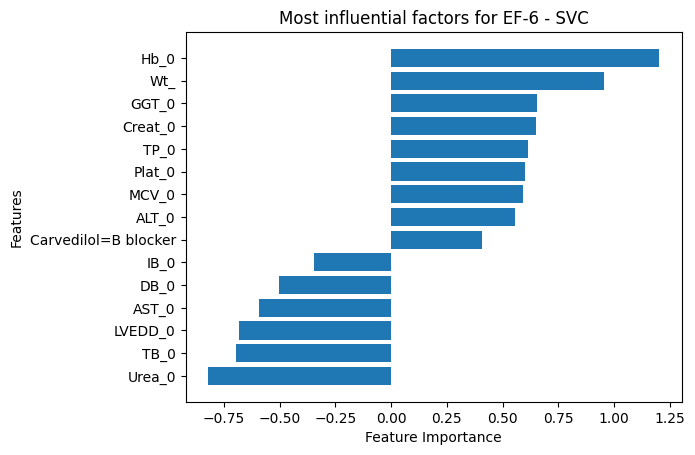

In [ ]:
estimator = SVC(kernel = 'linear', random_state=77, probability=True)

rfe = RFE(estimator, n_features_to_select=15, step = 1)
rfe.fit(X, Y_EF)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])

print('\n====== FEATURE RANKINGS =====')
#for f,i, r in zip(X.columns,rfecv.estimator_.feature_importances_, rfecv.ranking_):
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f,  r))

plotter(rfe, "coef", "EF-6 - SVC")

### Prominent Features influencing Y-EF6 using RFE (CatBoost Estimator)

Learning rate set to 0.043347
0:	learn: 0.6685136	total: 10ms	remaining: 993ms
1:	learn: 0.6413777	total: 17.4ms	remaining: 854ms
2:	learn: 0.6184621	total: 30.2ms	remaining: 978ms
3:	learn: 0.5959971	total: 43.3ms	remaining: 1.04s
4:	learn: 0.5761816	total: 53.6ms	remaining: 1.02s
5:	learn: 0.5623193	total: 61.1ms	remaining: 957ms
6:	learn: 0.5481301	total: 69.4ms	remaining: 922ms
7:	learn: 0.5301867	total: 80ms	remaining: 920ms
8:	learn: 0.5163759	total: 88.4ms	remaining: 894ms
9:	learn: 0.5052086	total: 96.7ms	remaining: 870ms
10:	learn: 0.4920701	total: 105ms	remaining: 847ms
11:	learn: 0.4789899	total: 113ms	remaining: 832ms
12:	learn: 0.4635603	total: 122ms	remaining: 814ms
13:	learn: 0.4504968	total: 129ms	remaining: 789ms
14:	learn: 0.4427878	total: 133ms	remaining: 752ms
15:	learn: 0.4315749	total: 137ms	remaining: 717ms
16:	learn: 0.4223300	total: 141ms	remaining: 689ms
17:	learn: 0.4114369	total: 145ms	remaining: 662ms
18:	learn: 0.4017399	total: 149ms	remaining: 636ms
19:	l

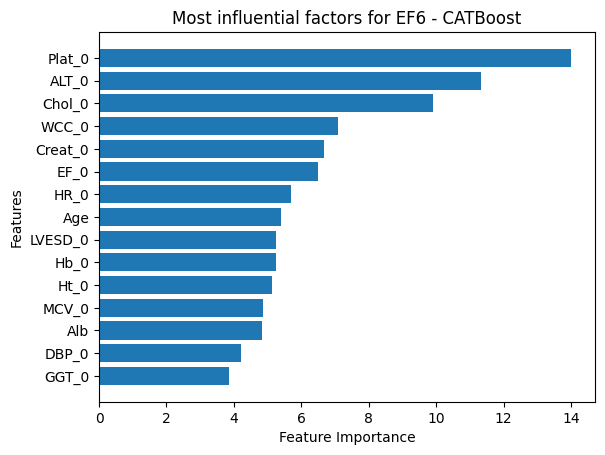

In [ ]:
estimator = CatBoostClassifier(iterations=100, random_seed= 77)
rfe = RFE(estimator, step=1, n_features_to_select=15)
rfe.fit(X, Y_EF)

print('Optimal number of features :', rfe.n_features_)
print('Best features :', X.columns[rfe.support_])

print('\n====== FEATURE RANKINGS =====')
for f, r in zip(X.columns, rfe.ranking_):
  print('{} \t\t {}'.format(f, r))

plotter(rfe, "FI", "EF6 - CATBoost")

# 3. PREDICTION

### SPLIT INTO TRAINING & TESTING SETS

In [ ]:
def split_scale(X, Y):
  #Training = 80%, Testing = 20%
  X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.2, random_state=77,shuffle=True)

  sc_X = StandardScaler()
  X_train = sc_X.fit_transform(X_train)
  X_test = sc_X.transform(X_test)

  return X_train, X_test, Y_train, Y_test

def printResult(prediction, y_test):
  from sklearn.metrics import r2_score, mean_squared_error, accuracy_score,confusion_matrix,classification_report

  print(f"Accuracy Score = {accuracy_score(y_test,prediction)*100}")
  print(f"Confusion Matrix =\n {confusion_matrix(y_test,prediction)}")
  print(f"Classification Report =\n {classification_report(y_test,prediction)}")
  #print('R2 score = ', r2_score(y_test,prediction))
  #print('mean_sqrd_error  = ', mean_squared_error(y_test,prediction))
  #print('root_mean_squared error = ', np.sqrt(mean_squared_error(y_test,prediction)))

### MLP

In [ ]:
def MLP (X_values, Y_values):
  X_train, X_test, Y_train, Y_test = split_scale(X_values, Y_values)

  classifier = Sequential()

  #34 input, 1 output, unit = (34+1)/2 = 17
  classifier.add(Dense(units = 17, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))
  classifier.add(Dense(units = 17, kernel_initializer = 'uniform', activation = 'relu'))
  #final layer, sigmoid for binary and softmax for multi-class (NYHA-6)
  classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid')) #
  classifier.add(Dropout(0.1))
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

  #from ann_visualizer.visualize import ann_viz;
  #ann_viz(network, title="");

  # Fitting the ANN to the Training set
  classifier.fit(X_train, Y_train, batch_size = 50, epochs = 500, verbose = 0)

  # Part 3 - Making predictions and evaluating the model

  # Predicting the Test set results
  y_pred = classifier.predict(X_test)
  y_pred = np.where(y_pred > 0.5, 1, 0)
  printResult(y_pred, Y_test)


In [ ]:
#MLP multi-class
def MLP2 (X_values, Y_values):
  X_train, X_test, Y_train, Y_test = split_scale(X_values, Y_values)

  classifier = Sequential()

  #34 input, 1 output, unit = (34+1)/2 = 17
  classifier.add(Dense(units = 17, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))
  classifier.add(Dense(units = 17, kernel_initializer = 'uniform', activation = 'relu'))
  #final layer, sigmoid for binary and softmax for multi-class (NYHA-6)
  classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'softmax')) #
  classifier.add(Dropout(0.1))
  classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


  # Fitting the ANN to the Training set
  classifier.fit(X_train, Y_train, batch_size = 50, epochs = 500, verbose = 0)

  # Part 3 - Making predictions and evaluating the model

  # Predicting the Test set results
  y_pred = classifier.predict(X_test)
  y_pred2 = np.argmax(y_pred, axis=1)

  printResult(y_pred2, Y_test)


#estimator = KerasClassifier(build_fn=classifier, epochs=500, batch_size=50, verbose=0)
#kfold = KFold(n_splits=10, shuffle=True)
#results = cross_val_score(estimator, X, dummy_y, cv=kfold)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

### RF

In [ ]:
def RF(X_values, Y_values):

  X_train, X_test, Y_train, Y_test = split_scale(X_values, Y_values)

  classifier = RandomForestClassifier(n_estimators = 100, random_state = 77)

  classifier.fit(X_train, Y_train)

  y_pred = classifier.predict(X_test)

  printResult(y_pred, Y_test)

### Catboost

In [ ]:
def catboost(X_values, Y_values):
  X_train, X_test, Y_train, Y_test = split_scale(X_values, Y_values)

  classifier = CatBoostClassifier(iterations=1000, random_seed= 77, verbose = 0)
  classifier.fit(X_train, Y_train)

  y_pred = classifier.predict(X_test)

  printResult(y_pred, Y_test)

### Log Reg

In [ ]:
def LogReg (X_values, Y_values):
  X_train, X_test, Y_train, Y_test = split_scale(X_values, Y_values)

  classifier = LogisticRegression(random_state=77)
  classifier.fit(X_train, Y_train)

  y_pred = classifier.predict(X_test)

  printResult(y_pred, Y_test)

### SVC

In [ ]:
def svc(X_values, Y_values):
  X_train, X_test, Y_train, Y_test = split_scale(X_values, Y_values)

  classifier = SVC(kernel = 'linear', random_state=77, probability=True)
  classifier.fit(X_train, Y_train)

  y_pred = classifier.predict(X_test)

  printResult(y_pred, Y_test)

## Predicting Survival

### Data characteristics

In [ ]:
Y_surv.value_counts()

# IMBALANCE!! Skewed towards survive

0.0    168
1.0     38
Name: Survived, dtype: int64

### Data Augmentation to get more Survived = 1 (i.e., did not survive)
### Augmenting by oversampling - creating more copies of Surivived = 1

In [ ]:
survived0 = data1[data1['Survived'] == 0] #168
survived1 = data1[data1['Survived'] == 1] #38

m = len(survived0) // len(survived1)
r = len(survived0) % len(survived1)

s1 = pd.concat([survived1] * m, axis = 0)
#s1_rem = survived1.iloc[:r]
s1_rem = survived1.sample(n = r, random_state= 77) # select r random rows

surv1 = pd.concat([s1, s1_rem], axis = 0)
balanced_data1 = pd.concat([survived0, surv1], axis = 0)

print("BEFORE AUGMENTATION = Survived0 = {} \t Survived1(Dead) = {}".format(survived0.shape, survived1.shape ))
print("AFTER AUGMENTATION = Survived0 = {} \t Survived1(Dead) = {}".format(survived0.shape, surv1.shape ))

BEFORE AUGMENTATION = Survived0 = (168, 39) 	 Survived1(Dead) = (38, 39)
AFTER AUGMENTATION = Survived0 = (168, 39) 	 Survived1(Dead) = (168, 39)


In [ ]:
np.unique(balanced_data1['Survived'], return_counts= 1)

(array([0., 1.]), array([168, 168]))

In [ ]:
# Create another ML data

#data1 = data1.drop('Number', axis = 1)
X2 = balanced_data1.drop(columns=targets, axis = 1)

Y_surv2 = balanced_data1['Survived'] #binary - no problem here

print("X2 = {}, Y_surv2 = {}".format(X2.shape, Y_surv2.shape))

X2 = (336, 34), Y_surv2 = (336,)


### Prediction using RANDOM FOREST

In [ ]:
#imbalance dataset
RF(X, Y_surv)

Accuracy Score = 88.09523809523809
Confusion Matrix =
 [[37  0]
 [ 5  0]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.88      1.00      0.94        37
         1.0       0.00      0.00      0.00         5

    accuracy                           0.88        42
   macro avg       0.44      0.50      0.47        42
weighted avg       0.78      0.88      0.83        42



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# RF ON BALANCE (AUGMENTED) DATASET

RF(X2, Y_surv2)

Accuracy Score = 97.05882352941177
Confusion Matrix =
 [[39  2]
 [ 0 27]]
Classification Report =
               precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        41
         1.0       0.93      1.00      0.96        27

    accuracy                           0.97        68
   macro avg       0.97      0.98      0.97        68
weighted avg       0.97      0.97      0.97        68



### Prediction using CATBoost

In [ ]:
# IMBALANCE DATASET
catboost(X, Y_surv)

Accuracy Score = 88.09523809523809
Confusion Matrix =
 [[37  0]
 [ 5  0]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.88      1.00      0.94        37
         1.0       0.00      0.00      0.00         5

    accuracy                           0.88        42
   macro avg       0.44      0.50      0.47        42
weighted avg       0.78      0.88      0.83        42



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# BALANCED DATASET

catboost(X2, Y_surv2)



Accuracy Score = 97.05882352941177
Confusion Matrix =
 [[39  2]
 [ 0 27]]
Classification Report =
               precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        41
         1.0       0.93      1.00      0.96        27

    accuracy                           0.97        68
   macro avg       0.97      0.98      0.97        68
weighted avg       0.97      0.97      0.97        68



### Prediction using SVC

In [ ]:
# Imbalance dataset
svc(X, Y_surv)

Accuracy Score = 78.57142857142857
Confusion Matrix =
 [[32  5]
 [ 4  1]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.89      0.86      0.88        37
         1.0       0.17      0.20      0.18         5

    accuracy                           0.79        42
   macro avg       0.53      0.53      0.53        42
weighted avg       0.80      0.79      0.79        42



In [ ]:
# Balance dataset
svc(X2, Y_surv2)

Accuracy Score = 69.11764705882352
Confusion Matrix =
 [[30 11]
 [10 17]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.75      0.73      0.74        41
         1.0       0.61      0.63      0.62        27

    accuracy                           0.69        68
   macro avg       0.68      0.68      0.68        68
weighted avg       0.69      0.69      0.69        68



### Predicting using Log Reg

In [ ]:
# Logistic Regression ON IMBALANCE DATASET

LogReg(X, Y_surv)

Accuracy Score = 80.95238095238095
Confusion Matrix =
 [[33  4]
 [ 4  1]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        37
         1.0       0.20      0.20      0.20         5

    accuracy                           0.81        42
   macro avg       0.55      0.55      0.55        42
weighted avg       0.81      0.81      0.81        42



In [ ]:
# LR ON BALANCE (AUGMENTED) DATASET

LogReg(X2, Y_surv2)

Accuracy Score = 77.94117647058823
Confusion Matrix =
 [[33  8]
 [ 7 20]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.82      0.80      0.81        41
         1.0       0.71      0.74      0.73        27

    accuracy                           0.78        68
   macro avg       0.77      0.77      0.77        68
weighted avg       0.78      0.78      0.78        68



### Predicting using NN - MLP

In [ ]:
MLP(X2, Y_surv2)

3/3 [==============================] - 0s 4ms/step
Accuracy Score = 95.58823529411765
Confusion Matrix =
 [[38  3]
 [ 0 27]]
Classification Report =
               precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        41
         1.0       0.90      1.00      0.95        27

    accuracy                           0.96        68
   macro avg       0.95      0.96      0.95        68
weighted avg       0.96      0.96      0.96        68



## EF6

In [ ]:
Y_EF.value_counts()

1    131
0     75
dtype: int64

In [ ]:
ef0 = data1[data1['EF_6']  < 0.35] #75
ef1 = data1[data1['EF_6'] >= 0.35] #131

#m = len(ef0) // len(ef1)
r = len(ef1) % len(ef0)

e0_rem = ef0.sample(n = r, random_state= 77) # select r random rows

ee0 = pd.concat([ef0, e0_rem], axis = 0)
balanced_data1 = pd.concat([ef1, ee0], axis = 0)

print("BEFORE AUGMENTATION = EF0 = {} \t EF1 = {}".format(ef0.shape, ef1.shape ))
print("AFTER AUGMENTATION = EF0 = {} \t EF1 = {}".format(ee0.shape, ef1.shape ))

BEFORE AUGMENTATION = EF0 = (75, 39) 	 EF1 = (131, 39)
AFTER AUGMENTATION = EF0 = (131, 39) 	 EF1 = (131, 39)


In [ ]:
# Create another ML data

#data1 = data1.drop('Number', axis = 1)
X2 = balanced_data1.drop(columns=targets, axis = 1)

Y_EF2 = pd.Series(np.where(balanced_data1['EF_6'] >= 0.35, 1, 0))

print("X2 = {}, Y_EF2 = {}".format(X2.shape, Y_EF2.shape))

X2 = (262, 34), Y_EF2 = (262,)


###Using RF

In [ ]:
# RANDOM FOREST ON IMBALANCE DATASET
RF(X, Y_EF)

Accuracy Score = 80.95238095238095
Confusion Matrix =
 [[ 9  6]
 [ 2 25]]
Classification Report =
               precision    recall  f1-score   support

           0       0.82      0.60      0.69        15
           1       0.81      0.93      0.86        27

    accuracy                           0.81        42
   macro avg       0.81      0.76      0.78        42
weighted avg       0.81      0.81      0.80        42



In [ ]:
# RF ON BALANCE (AUGMENTED) DATASET
RF(X2, Y_EF2)

Accuracy Score = 90.56603773584906
Confusion Matrix =
 [[20  4]
 [ 1 28]]
Classification Report =
               precision    recall  f1-score   support

           0       0.95      0.83      0.89        24
           1       0.88      0.97      0.92        29

    accuracy                           0.91        53
   macro avg       0.91      0.90      0.90        53
weighted avg       0.91      0.91      0.90        53



### Using CATBoost

In [ ]:
# IMBALANCE DATASET
catboost(X, Y_EF)

Accuracy Score = 83.33333333333334
Confusion Matrix =
 [[ 9  6]
 [ 1 26]]
Classification Report =
               precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.81      0.96      0.88        27

    accuracy                           0.83        42
   macro avg       0.86      0.78      0.80        42
weighted avg       0.84      0.83      0.82        42



In [ ]:
# BALANCED DATASET
catboost(X2, Y_EF2)

Accuracy Score = 92.45283018867924
Confusion Matrix =
 [[20  4]
 [ 0 29]]
Classification Report =
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       0.88      1.00      0.94        29

    accuracy                           0.92        53
   macro avg       0.94      0.92      0.92        53
weighted avg       0.93      0.92      0.92        53



### Using SVC

In [ ]:
# Imbalance dataset
svc(X, Y_EF)

Accuracy Score = 80.95238095238095
Confusion Matrix =
 [[12  3]
 [ 5 22]]
Classification Report =
               precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.88      0.81      0.85        27

    accuracy                           0.81        42
   macro avg       0.79      0.81      0.80        42
weighted avg       0.82      0.81      0.81        42



In [ ]:
# balance dataset
svc(X2, Y_EF2)

Accuracy Score = 77.35849056603774
Confusion Matrix =
 [[19  5]
 [ 7 22]]
Classification Report =
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        24
           1       0.81      0.76      0.79        29

    accuracy                           0.77        53
   macro avg       0.77      0.78      0.77        53
weighted avg       0.78      0.77      0.77        53



### Using Log Reg

In [ ]:
# Logistic Regression ON IMBALANCE DATASET
LogReg(X, Y_EF)

Accuracy Score = 83.33333333333334
Confusion Matrix =
 [[12  3]
 [ 4 23]]
Classification Report =
               precision    recall  f1-score   support

           0       0.75      0.80      0.77        15
           1       0.88      0.85      0.87        27

    accuracy                           0.83        42
   macro avg       0.82      0.83      0.82        42
weighted avg       0.84      0.83      0.83        42



In [ ]:
# LR ON BALANCE (AUGMENTED) DATASET
LogReg(X2, Y_EF2)

Accuracy Score = 79.24528301886792
Confusion Matrix =
 [[18  6]
 [ 5 24]]
Classification Report =
               precision    recall  f1-score   support

           0       0.78      0.75      0.77        24
           1       0.80      0.83      0.81        29

    accuracy                           0.79        53
   macro avg       0.79      0.79      0.79        53
weighted avg       0.79      0.79      0.79        53



### Neural Networks

In [ ]:
#balanced data
MLP(X2, Y_EF2)

2/2 [==============================] - 0s 8ms/step
Accuracy Score = 79.24528301886792
Confusion Matrix =
 [[21  3]
 [ 8 21]]
Classification Report =
               precision    recall  f1-score   support

           0       0.72      0.88      0.79        24
           1       0.88      0.72      0.79        29

    accuracy                           0.79        53
   macro avg       0.80      0.80      0.79        53
weighted avg       0.81      0.79      0.79        53



## Predict NYHA6

#### Data characteristics

In [ ]:
#Y_NYHA.value_counts()
data1['NYHA_6'].value_counts()
#imbalance set

0.25    104
0.50     47
0.00     37
0.75     15
1.00      3
Name: NYHA_6, dtype: int64

#### Augmenting across all groups

In [ ]:
#making all groups have 104 entries

a0 = data1[data1['NYHA_6'] == 0.0] #37
a1 = data1[data1['NYHA_6'] == 0.25] #104
a2 = data1[data1['NYHA_6'] == 0.50] #47
a3 = data1[data1['NYHA_6'] == 0.75] #15
a4 = data1[data1['NYHA_6'] == 1.00] #3

az = [a0, a2, a3, a4]
new_az = []

for a in az:

  m = len(a1) // len(a)
  r = len(a1) % len(a)

  _a = pd.concat([a] * m, axis = 0)
  _a_r = a.sample(n = r, random_state= 77) # select r random rows

  new_az.append(pd.concat([_a, _a_r], axis = 0))


balanced_az = pd.concat([a for a in new_az], axis = 0)
balanced_az = pd.concat([balanced_az, a1], axis = 0)

np.unique(balanced_az['NYHA_6'], return_counts= 1)

(array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([104, 104, 104, 104, 104]))

In [ ]:
# Create another ML data

X2 = balanced_az.drop(columns=targets, axis = 1)

Y_NYHA2 = balanced_az['NYHA_6']
Y_NYHA2 = Y_NYHA2.replace({0.00:0, 0.25:1, 0.50:2, 0.75:3, 1.00:4})

print("X2 = {}, Y_NYHA2 = {}".format(X2.shape, Y_NYHA2.shape))

X2 = (520, 34), Y_NYHA2 = (520,)


In [ ]:
#one hot encode Y_NYHA6 for RF and ANN
hot_NYHA =  keras.utils.to_categorical(Y_NYHA2, num_classes = 5)

### Using RANDOM FOREST

In [ ]:
#Imbalance dataset
RF(X, Y_NYHA)

Accuracy Score = 54.761904761904766
Confusion Matrix =
 [[ 1  2  2  0]
 [ 0 20  4  0]
 [ 0  8  2  0]
 [ 0  1  2  0]]
Classification Report =
               precision    recall  f1-score   support

         0.0       1.00      0.20      0.33         5
         1.0       0.65      0.83      0.73        24
         2.0       0.20      0.20      0.20        10
         3.0       0.00      0.00      0.00         3

    accuracy                           0.55        42
   macro avg       0.46      0.31      0.32        42
weighted avg       0.54      0.55      0.50        42



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Balanced dataset
RF(X2, Y_NYHA2)

Accuracy Score = 87.5
Confusion Matrix =
 [[22  3  3  0  0]
 [ 2 14  3  0  0]
 [ 0  2 24  0  0]
 [ 0  0  0 15  0]
 [ 0  0  0  0 16]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.92      0.79      0.85        28
         1.0       0.74      0.74      0.74        19
         2.0       0.80      0.92      0.86        26
         3.0       1.00      1.00      1.00        15
         4.0       1.00      1.00      1.00        16

    accuracy                           0.88       104
   macro avg       0.89      0.89      0.89       104
weighted avg       0.88      0.88      0.87       104



### Using CATBoost

In [ ]:
# IMBALANCE DATASET
catboost(X, Y_NYHA)

Accuracy Score = 61.904761904761905
Confusion Matrix =
 [[ 2  2  1  0]
 [ 0 20  4  0]
 [ 0  6  4  0]
 [ 0  2  1  0]]
Classification Report =
               precision    recall  f1-score   support

         0.0       1.00      0.40      0.57         5
         1.0       0.67      0.83      0.74        24
         2.0       0.40      0.40      0.40        10
         3.0       0.00      0.00      0.00         3

    accuracy                           0.62        42
   macro avg       0.52      0.41      0.43        42
weighted avg       0.60      0.62      0.59        42



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# BALANCE DATASET
catboost(X2, Y_NYHA2)

Accuracy Score = 87.5
Confusion Matrix =
 [[22  3  3  0  0]
 [ 2 14  3  0  0]
 [ 0  2 24  0  0]
 [ 0  0  0 15  0]
 [ 0  0  0  0 16]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.92      0.79      0.85        28
         1.0       0.74      0.74      0.74        19
         2.0       0.80      0.92      0.86        26
         3.0       1.00      1.00      1.00        15
         4.0       1.00      1.00      1.00        16

    accuracy                           0.88       104
   macro avg       0.89      0.89      0.89       104
weighted avg       0.88      0.88      0.87       104



### Using SVC

In [ ]:
#Imbalance dataset
svc(X, Y_NYHA)

Accuracy Score = 42.857142857142854
Confusion Matrix =
 [[ 2  2  1  0]
 [ 5 14  5  0]
 [ 3  5  2  0]
 [ 1  1  1  0]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.18      0.40      0.25         5
         1.0       0.64      0.58      0.61        24
         2.0       0.22      0.20      0.21        10
         3.0       0.00      0.00      0.00         3

    accuracy                           0.43        42
   macro avg       0.26      0.30      0.27        42
weighted avg       0.44      0.43      0.43        42



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Balanced dataset
svc(X2, Y_NYHA2)

Accuracy Score = 74.03846153846155
Confusion Matrix =
 [[22  6  0  0  0]
 [ 4  9  1  5  0]
 [ 2  7 15  2  0]
 [ 0  0  0 15  0]
 [ 0  0  0  0 16]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.79      0.79      0.79        28
         1.0       0.41      0.47      0.44        19
         2.0       0.94      0.58      0.71        26
         3.0       0.68      1.00      0.81        15
         4.0       1.00      1.00      1.00        16

    accuracy                           0.74       104
   macro avg       0.76      0.77      0.75       104
weighted avg       0.77      0.74      0.74       104



### Using LR

In [ ]:
#Imbalance dataset
LogReg(X, Y_NYHA)

Accuracy Score = 50.0
Confusion Matrix =
 [[ 2  2  1  0]
 [ 4 15  3  2]
 [ 1  6  3  0]
 [ 0  2  0  1]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.29      0.40      0.33         5
         1.0       0.60      0.62      0.61        24
         2.0       0.43      0.30      0.35        10
         3.0       0.33      0.33      0.33         3

    accuracy                           0.50        42
   macro avg       0.41      0.41      0.41        42
weighted avg       0.50      0.50      0.50        42



In [ ]:
#Balanced dataset
LogReg(X2, Y_NYHA2)

Accuracy Score = 67.3076923076923
Confusion Matrix =
 [[16  8  1  3  0]
 [ 2  9  2  6  0]
 [ 4  3 16  3  0]
 [ 0  0  2 13  0]
 [ 0  0  0  0 16]]
Classification Report =
               precision    recall  f1-score   support

         0.0       0.73      0.57      0.64        28
         1.0       0.45      0.47      0.46        19
         2.0       0.76      0.62      0.68        26
         3.0       0.52      0.87      0.65        15
         4.0       1.00      1.00      1.00        16

    accuracy                           0.67       104
   macro avg       0.69      0.71      0.69       104
weighted avg       0.70      0.67      0.67       104



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### NN - MLP

In [ ]:
MLP2(X2, hot_NYHA)

4/4 [==============================] - 0s 4ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [ ]:
#MLP(X2, hot_NYHA)

#MLP multi-class

X_train, X_test, Y_train, Y_test = split_scale(X2, hot_NYHA)

classifier = Sequential()

#34 input, 1 output, unit = (34+1)/2 = 17
classifier.add(Dense(units = 17, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))
classifier.add(Dense(units = 17, kernel_initializer = 'uniform', activation = 'relu'))
#final layer, sigmoid for binary and softmax for multi-class (NYHA-6)
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'softmax')) #
classifier.add(Dropout(0.1))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


# Fitting the ANN to the Training set
classifier.fit(X_train, Y_train, batch_size = 50, epochs = 500, verbose = 0)

# Part 3 - Making predictions

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred2 = np.argmax(y_pred, axis=1)

In [ ]:
#4. Evaluate the model

#convert Y_test (OneHotEncoded) back to normal
nom_Y_test = pd.DataFrame(Y_test).idxmax(1)

#then get performance result

printResult(y_pred2, nom_Y_test)

Accuracy Score = 82.6923076923077
Confusion Matrix =
 [[22  6  0  0  0]
 [ 2  9  4  3  1]
 [ 0  2 24  0  0]
 [ 0  0  0 15  0]
 [ 0  0  0  0 16]]
Classification Report =
               precision    recall  f1-score   support

           0       0.92      0.79      0.85        28
           1       0.53      0.47      0.50        19
           2       0.86      0.92      0.89        26
           3       0.83      1.00      0.91        15
           4       0.94      1.00      0.97        16

    accuracy                           0.83       104
   macro avg       0.82      0.84      0.82       104
weighted avg       0.82      0.83      0.82       104

